<h2>Prototype</h2>

In [140]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import get_window
from scipy.signal import resample
from scipy.io import wavfile
from scipy.signal import savgol_filter
from scipy.signal import wiener
import IPython
import json
from fastdtw import fastdtw

In [102]:
fs, x = wavfile.read("samples/tu-jesty-fata.wav")
x = x / np.max(abs(x))

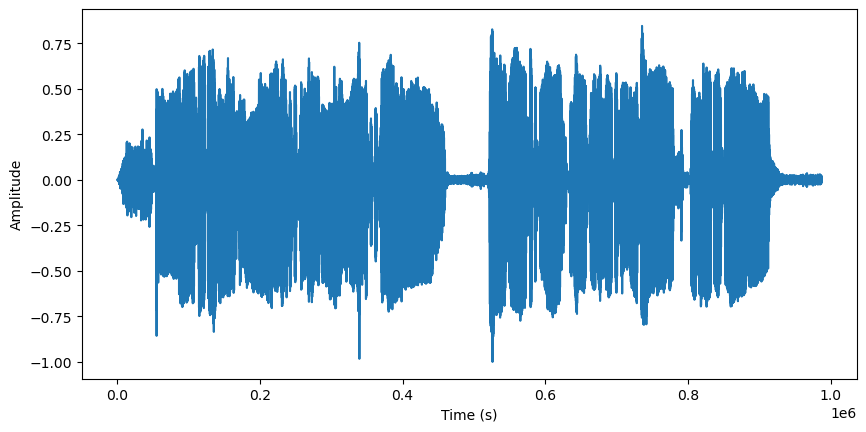

In [103]:
plt.figure().set_figwidth(10)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(x)
IPython.display.Audio(x, rate=fs)

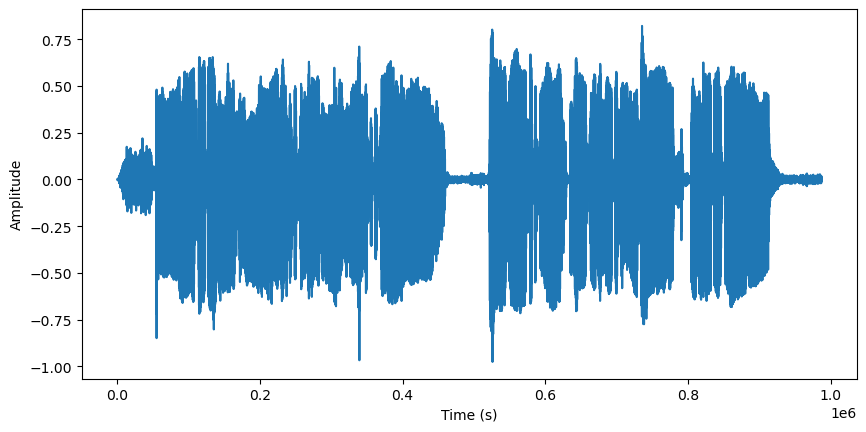

In [104]:
x = wiener(x, mysize=10)

plt.figure().set_figwidth(10)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(x)
IPython.display.Audio(x, rate=fs)

In [105]:
M = 8191
N = 8192
H = 1024

hM1 = int(math.floor((M + 1) / 2))
hM2 = int(math.floor(M / 2))
eps = np.finfo(float).eps

In [106]:
w  = get_window('hamming', M)
w = w / sum(w)

In [107]:
def computeSpectrum(x):
    spectrum = []
    
    l = 0
    while l < len(x) - M:
        y = x[l: l + M]
        
        rmsframe = np.sqrt(np.dot(y, y) / M)    
        
        if rmsframe > 0.1:
            y = y / np.max(abs(y))
            y = y * w

            fftBuffer = np.zeros(N)
            fftBuffer[: hM1] = y[hM2:] 
            fftBuffer[N - hM2:] = y[: hM2]

            X = fft(fftBuffer)
            absX = abs(X)
            absX[absX < np.finfo(float).eps] = np.finfo(float).eps
            mX = 10 * np.log10(absX)

            spectrum.append(mX)

        l += H
    
    return spectrum

In [108]:
spectrum = computeSpectrum(x)

In [109]:
timeSteps = np.arange(len(spectrum)) * H / fs
frequencies = np.arange(N) * fs / N
cutoff = int(1000 * N / fs)

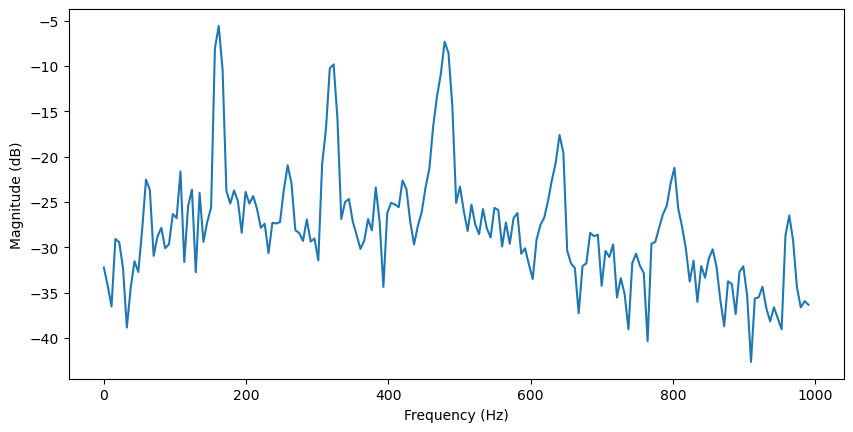

In [110]:
plt.figure().set_figwidth(10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(frequencies[:cutoff], spectrum[50][:cutoff])

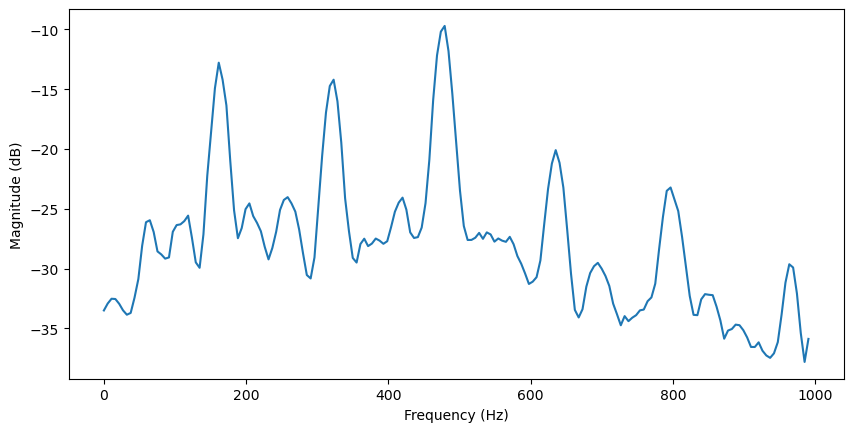

In [111]:
filteredSpectrum = savgol_filter(spectrum[50][:cutoff], 15, 5)

plt.figure().set_figwidth(10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(frequencies[:cutoff], filteredSpectrum)

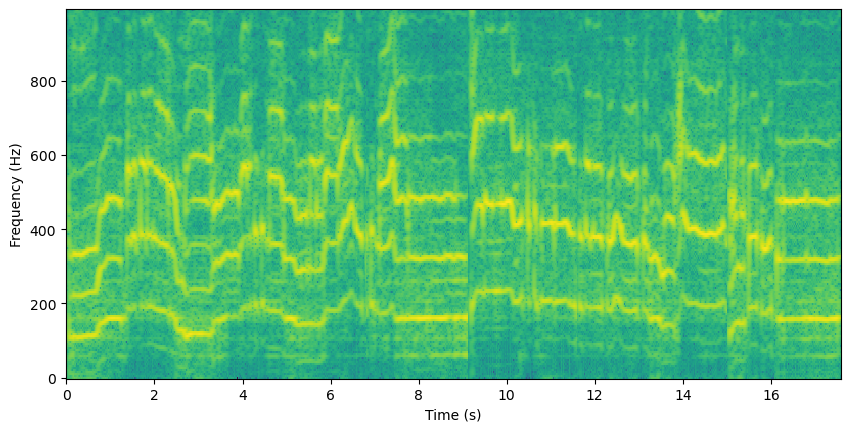

In [112]:
f = int(2500 * N / fs)
spectrum = np.array(spectrum)

plt.figure().set_figwidth(10)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(timeSteps, frequencies[:cutoff], spectrum.T[:cutoff])

In [113]:
peakFrequencies = []
peakMagnitudes = []

for i in range(len(spectrum)):
    mX = savgol_filter(spectrum[i][:cutoff], 15, 5)
    
    currentPeakFrequencies = []
    currentPeakMagnitudes = []
    
    k = 15
    while k < len(mX) - 1:
        if len(currentPeakFrequencies) == 8:
            break
                
        if mX[k] < -25: 
            k += 1
            continue

        if mX[k-1] < mX[k] and mX[k] > mX[k+1]:
            segment = np.zeros(len(mX)) - 100
            segment[k:k+15] = mX[k:k+15]
            
            currentPeakFrequencies.append(np.argmax(segment) * fs / N)
            currentPeakMagnitudes.append(mX[np.argmax(segment)])
            
            k = np.argmax(segment) + 5
            
        else: k += 1

    peakFrequencies.append(currentPeakFrequencies)
    peakMagnitudes.append(currentPeakMagnitudes)

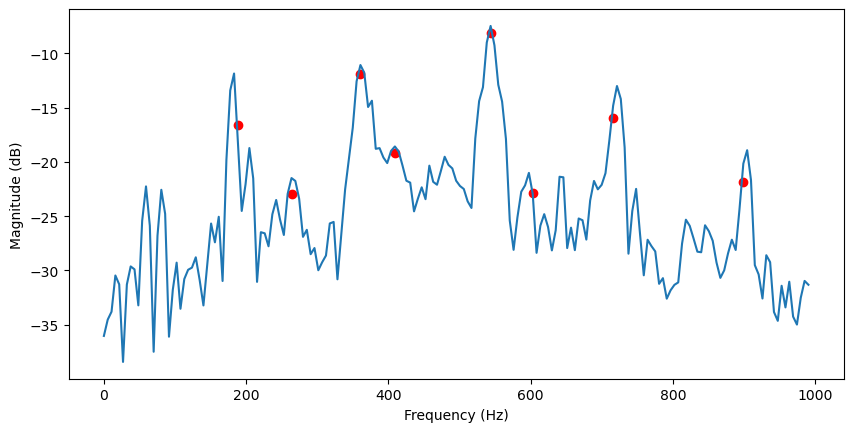

In [114]:
plt.figure().set_figwidth(10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(frequencies[:cutoff], spectrum[200][:cutoff])
plt.scatter(peakFrequencies[200], peakMagnitudes[200], c='r')

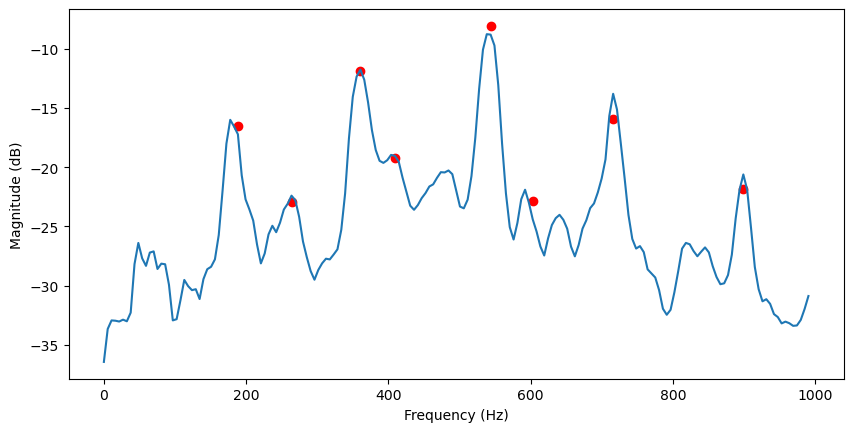

In [115]:
plt.figure().set_figwidth(10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(frequencies[:cutoff], savgol_filter(spectrum[200][:cutoff], 12, 5))
plt.scatter(peakFrequencies[200], peakMagnitudes[200], c='r')

In [116]:
for i in range(len(peakFrequencies)):
    for j in range(len(peakFrequencies[i])):
        p = int(peakFrequencies[i][j] * N / fs)
        
        for k in range(p-2, p+2):
            if spectrum[i][k] > peakMagnitudes[i][j]:
                peakMagnitudes[i][j] = spectrum[i][k]
                peakFrequencies[i][j] = k * fs / N

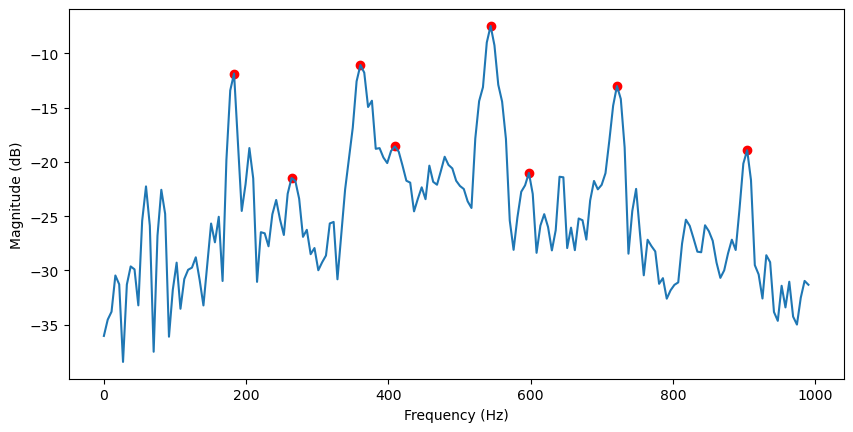

In [117]:
plt.figure().set_figwidth(10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(frequencies[:cutoff], spectrum[200][:cutoff])
plt.scatter(peakFrequencies[200], peakMagnitudes[200], c='r')

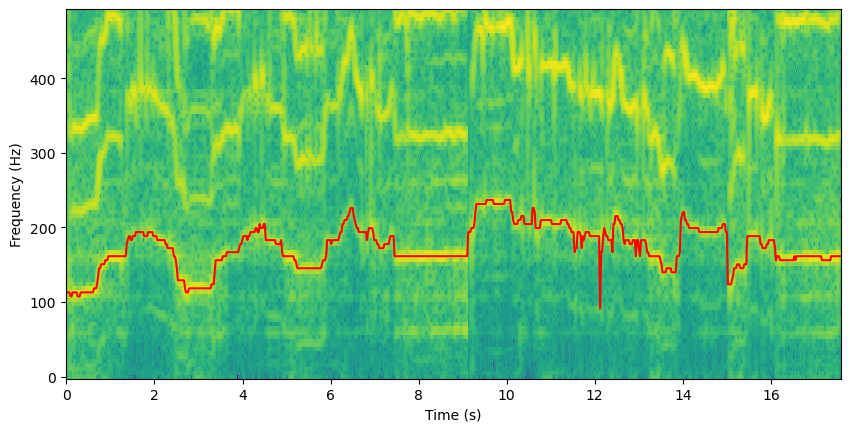

In [118]:
plt.figure().set_figwidth(10)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(timeSteps, frequencies[:int(cutoff/2)], spectrum.T[:int(cutoff/2)])
plt.plot(timeSteps, [p[0] for p in peakFrequencies], c='r')

In [123]:
fundamentalFrequencies = []

for i in range(len(peakFrequencies)):
    candidateFrequencies = []
    
    for j in range(len(peakFrequencies[i]) - 1):
        currentCandidate = peakFrequencies[i][j+1] - peakFrequencies[i][j]
        
        if currentCandidate > 80 and currentCandidate < 255:
            candidateFrequencies.append(currentCandidate)
        
    if len(candidateFrequencies) == 0:
        f0 = 100
        
    else: 
        f0 = candidateFrequencies[0]
        least_error = 99999

        for candidate in candidateFrequencies:
            error_pm = 0
            error_mp = 0

            harmonics = candidate
            predictedFrequencies = []
            
            k = 1
            while harmonics < peakFrequencies[i][-1] + candidate:
                predictedFrequencies.append(harmonics)
                harmonics += candidate

            for j in range(len(peakFrequencies[i])):
                differences = np.array([np.abs(predictedFrequency - peakFrequencies[i][j]) for predictedFrequency in predictedFrequencies])
                closestHarmonic = predictedFrequencies[differences.argmin()]

                error_pm += (closestHarmonic - peakFrequencies[i][j]) * (closestHarmonic) ** (-0.5) + peakMagnitudes[i][j] / (max(peakMagnitudes[i]) - 0.01) * (1.4 * (closestHarmonic - peakFrequencies[i][j]) * (closestHarmonic) ** (-0.5) - 0.5)
                error_mp += (closestHarmonic - peakFrequencies[i][j]) * (peakFrequencies[i][j]) ** (-0.5) + peakMagnitudes[i][j] / (max(peakMagnitudes[i]) - 0.01) * (1.4 * (closestHarmonic - peakFrequencies[i][j]) * (peakFrequencies[i][j]) ** (-0.5) - 0.5)

            error_total = (error_pm + error_mp) / len(peakFrequencies[i])
            
            if error_total < least_error:
                least_error = error_total
                f0 = candidate
    
    fundamentalFrequencies.append(f0)

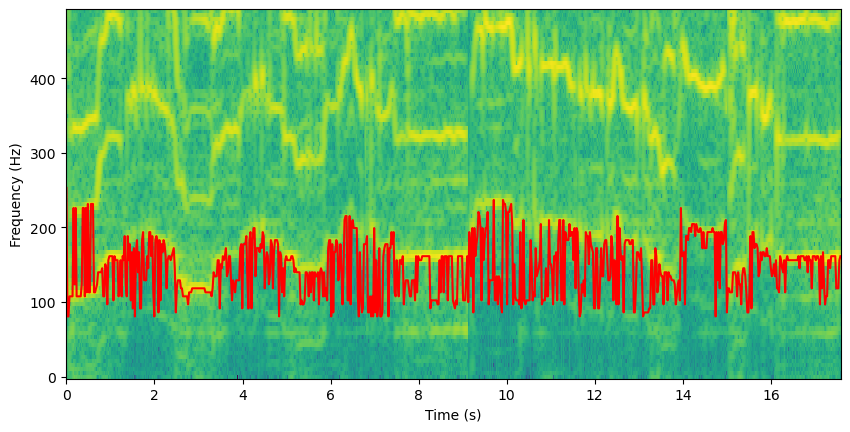

In [125]:
plt.figure().set_figwidth(10)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(timeSteps, frequencies[:int(cutoff/2)], spectrum.T[:int(cutoff/2)])
plt.plot(timeSteps, fundamentalFrequencies, c='r')

<h4>Needs a nueral network to identify the peaks</h4>

In [126]:
#notes = np.round([69 + 12 * np.log2((f0 + 0.0001) / 440) for f0 in fundamentals if f0 is not None]).tolist()
notes = np.round([69 + 12 * np.log2((f0 + 0.0001) / 440) for f0 in [p[0] for p in peakFrequencies]]).tolist()

noteFrequencies = [440 * (2 ** ((note - 69) / 12)) for note in notes] 

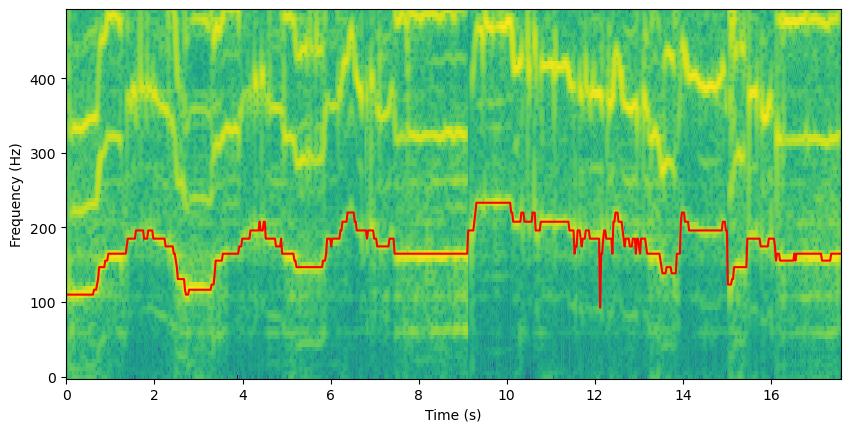

In [127]:
plt.figure().set_figwidth(10)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(timeSteps, frequencies[:int(cutoff/2)], spectrum.T[:int(cutoff/2)])
plt.plot(timeSteps, noteFrequencies, c='r')

In [128]:
with open('midi/tu-jesty-fata.json', 'r') as fp:
    tu_jesty_fata = json.load(fp)['melody']
    
with open('midi/talasaki.json', 'r') as fp:
    talasaki = json.load(fp)['melody']

In [129]:
tu_jesty_fata = (np.array(tu_jesty_fata) - int(np.mean(tu_jesty_fata))).tolist()
talasaki = (np.array(talasaki) - int(np.mean(talasaki))).tolist()
notes = (np.array(notes) - int(np.mean(notes))).tolist()

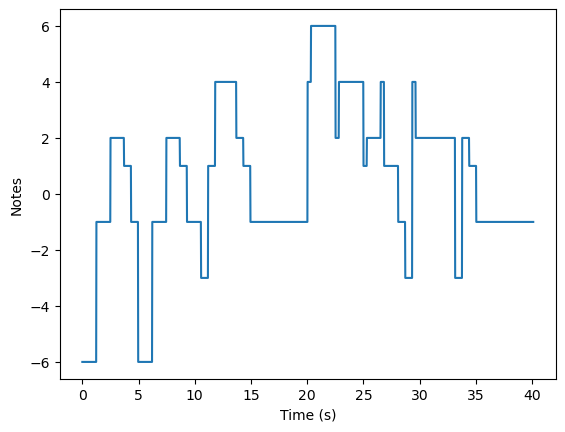

In [130]:
plt.xlabel('Time (s)')
plt.ylabel('Notes')
tu_jesty_fata_timeStep = np.arange(len(tu_jesty_fata)) * H / fs
plt.plot(tu_jesty_fata_timeStep, tu_jesty_fata)

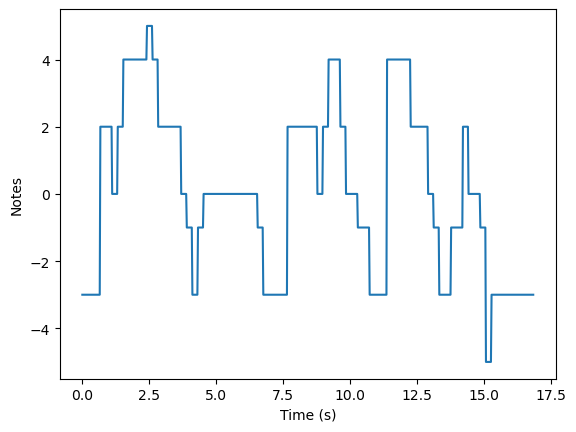

In [131]:
plt.xlabel('Time (s)')
plt.ylabel('Notes')
talasaki_timeStep = np.arange(len(talasaki)) * H / fs
plt.plot(talasaki_timeStep, talasaki)

In [132]:
standardDeviations = []
for i in range(len(notes)):
    if i < 5:
        standardDeviations.append(np.std(notes[0:i + 1]))
    else:
        standardDeviations.append(np.std(notes[i - 3: i + 1]))

In [133]:
stableNotes = []
for i in range(len(standardDeviations)):
    if standardDeviations[i] < 1:
        stableNotes.append(notes[i]);

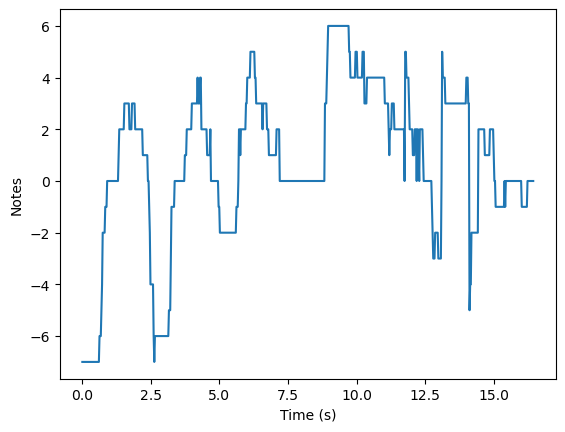

In [134]:
plt.xlabel('Time (s)')
plt.ylabel('Notes')
stableNotes_timeStep = np.arange(len(stableNotes)) * H / fs
plt.plot(stableNotes_timeStep, stableNotes)

In [151]:
distance_tu_jesty_fata, path_tu_jesty_fata = fastdtw(stableNotes, tu_jesty_fata)
distance_talasaki, path_talasaki = fastdtw(stableNotes, talasaki)

print(f"Similarity to Tu jesty fata: {100 / distance_tu_jesty_fata}")
print(f"Similarity to talasaki: {100 / distance_talasaki}")

Similarity to Tu jesty fata: 0.12376237623762376
Similarity to talasaki: 0.07942811755361398


In [152]:
x_tu_jesty_fata, y_tu_jesty_fata = zip(*path_tu_jesty_fata)
x_talasaki, y_talasaki = zip(*path_talasaki)

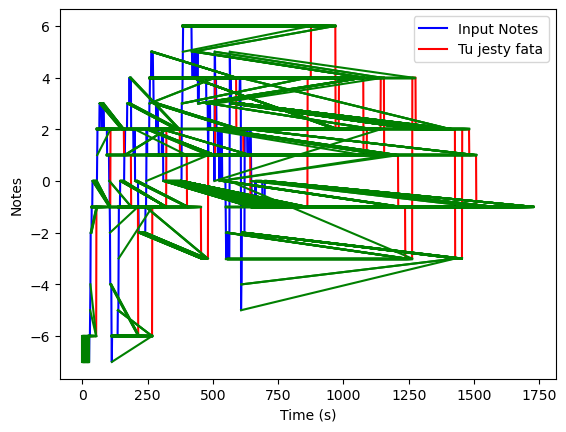

In [150]:
plt.xlabel('Time (s)')
plt.ylabel('Notes')

plt.plot(stableNotes, label='Input Notes', color='blue')
plt.plot(tu_jesty_fata, label='Tu jesty fata', color='red')
plt.legend()

for i, j in zip(x_tu_jesty_fata, y_tu_jesty_fata):
    plt.plot([i, j], [stableNotes[i], tu_jesty_fata[j]], color='green')

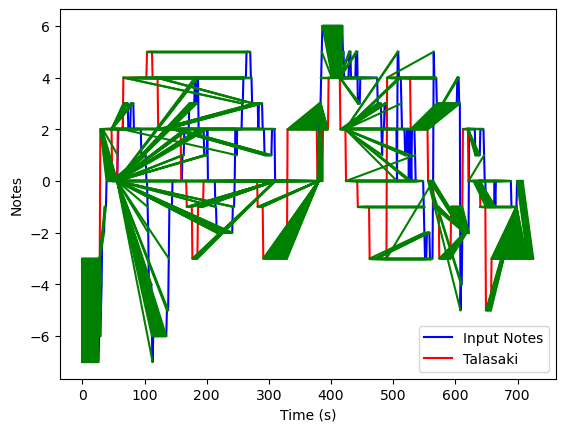

In [153]:
plt.xlabel('Time (s)')
plt.ylabel('Notes')

plt.plot(stableNotes, label='Input Notes', color='blue')
plt.plot(talasaki, label='Talasaki', color='red')
plt.legend()

for i, j in zip(x_talasaki, y_talasaki):
    plt.plot([i, j], [stableNotes[i], talasaki[j]], color='green')

In [136]:
if distance_tu_jesty_fata < distance_talasaki:
    print('The song is Tu jesty fata')
else:
    print('The song is Talasaki')

The song is Tu jesty fata
